In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.tikhonov as tikhonov
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/Duffing_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)


# 2) LOAD OBSERVATION SAMPLES
Y_samples = []
noise_lvl = '0.1'

for state in range(n_states):
    
    filepath = 'data_files/Duffing_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')
        
    Y_samples.append(y)
    
n_samples = Y_samples[0].shape[0]

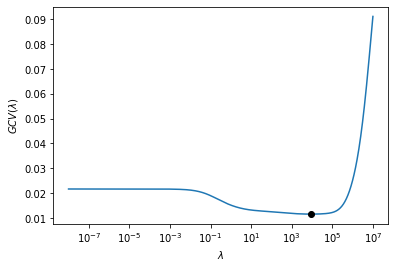

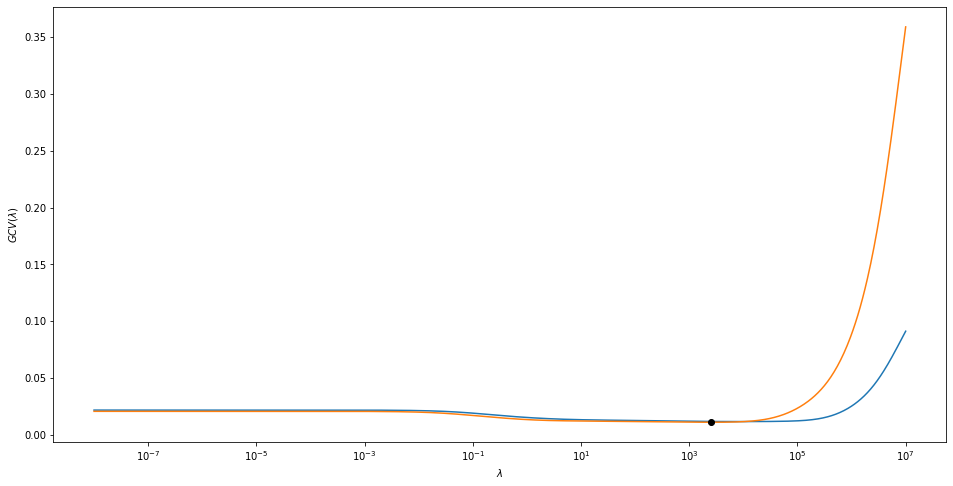

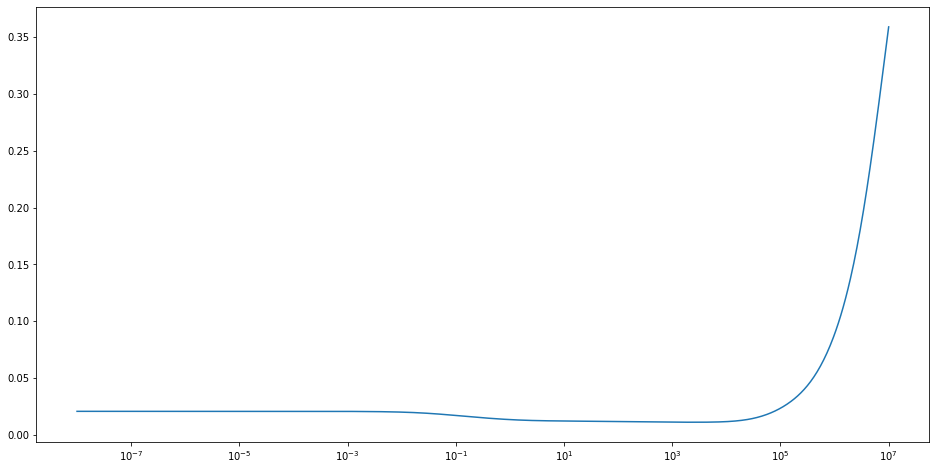

In [15]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
Y_tf = np.zeros((t_samples, n_states))
DY_tf = np.zeros((t_samples, n_states))
error_X = np.zeros((n_samples,n_states))
error_dX = np.zeros((n_samples,n_states))
trim = int(np.floor(5 / 100 * t_samples))


for sample in range(1):
    #CVX code
    for state in range(n_states):
        
        y = Y_samples[state][sample,:]
        
        #Find optimal lambda through GCV
        tik = tikhonov.gcv(y, lambda_min = 1e-8, lambda_max = 10000000, n_lambdas = 1000, plot_lc = True)
        y_tik = tik[0]
        lambdas, gcv = tik[1]
        plt.figure(figsize = (16,8))
        plt.semilogx(lambdas, gcv)
        
        y_tik_ss = interpolate.splrep(t, y_tik, k=3, s=0)
        dy_tik = interpolate.splev(t, y_tik_ss, der=1)
        
        #Remove ends
        Yhat_tik = y_tik[trim:-trim]
        DYhat_tik = dy_tik[trim:-trim]
        #Compute errors
        error_X[sample,state] = norm(Yhat_tik - X[state,trim:-trim]) / norm(X[state,trim:-trim])
        error_dX[sample,state] = norm(DYhat_tik - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])

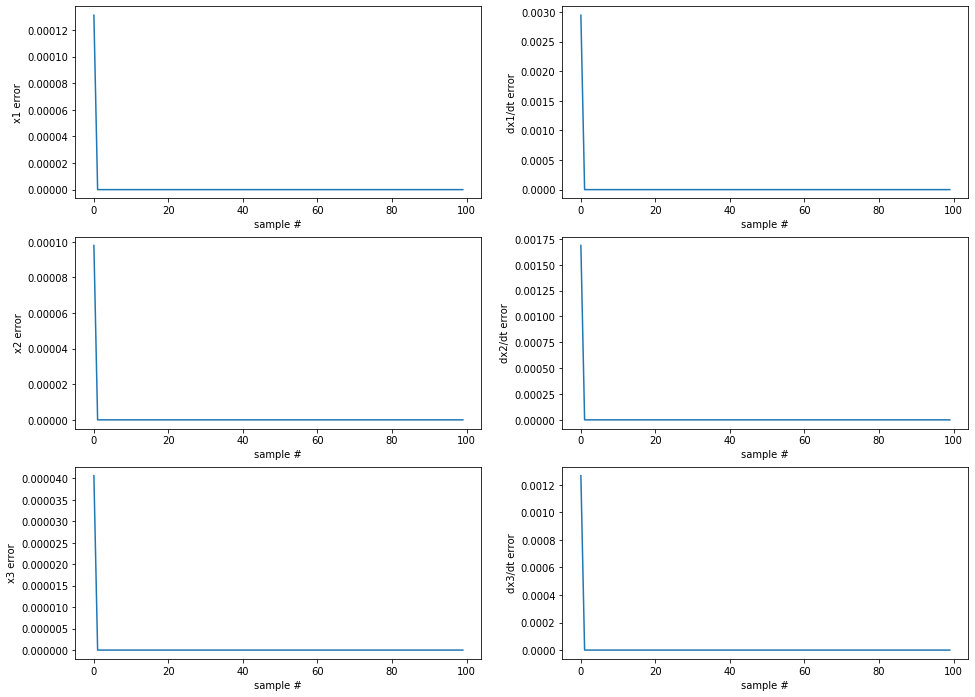

In [4]:
fig, ax = plt.subplots(n_states,2, figsize = (16,12))

for state in range(n_states):
    ax[state][0].plot(error_X[:,state])
    ax[state][0].set_ylabel(f'x{state+1} error')
    ax[state][0].set_xlabel('sample #')
    ax[state][1].plot(error_dX[:,state])
    ax[state][1].set_ylabel(f'dx{state+1}/dt error')
    ax[state][1].set_xlabel('sample #')

In [5]:
mean_X_error = np.zeros(n_states)
mean_dX_error = np.zeros(n_states)

var_X_error = np.zeros(n_states)
var_dX_error = np.zeros(n_states)

ind_names = []
col_names = ['mean error x', 'var. error x', 'mean error dx', 'var. error dx']

for state in range(n_states):
    mean_X_error[state] = error_X[:,state].mean()
    mean_dX_error[state] = error_dX[:,state].mean()
    var_X_error[state] = error_X[:,state].var()
    var_dX_error[state] = error_dX[:,state].var()
    ind_names.extend(['state x' + str(state+1)])
    

In [6]:
errors = pd.DataFrame(np.array([mean_X_error, var_X_error, mean_dX_error, var_dX_error]).T, index = ind_names, columns=col_names)
errors

,mean error x,var. error x,mean error dx,var. error dx
state x1,1.311009e-06,1.701558e-10,0.000029,8.603885e-08
state x2,9.801926e-07,9.511697e-11,0.000017,2.818496e-08
state x3,4.066121e-07,1.636801e-11,0.000013,1.589083e-08
